In [1]:
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, spearmanr, pearsonr
import os
from Metrics.metrics import expected_calibration_error, adaECE_error_mukhoti as adaECE_error, ClasswiseECELoss
from Utils.temperature_scaling import ModelWithTemperature

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Define the dataset
class MoGData(object):
  def __init__(self, dimension=2, num_classes=2, magnitude=10):
    # Define the parameters for the two Gaussian distributions
    self.dimension = dimension
    self.num_classes = num_classes
    self.magnitude = magnitude
    self.mu = np.zeros((num_classes, dimension))
    self.sigma = np.zeros((num_classes, dimension, dimension))
    self.distrib = []

    for i in range(num_classes):
      for j in range(dimension):
        self.mu[i, j] = np.random.uniform(-self.magnitude, self.magnitude)
      # Identity matrix for variance
      self.sigma[i] = np.eye(dimension)  
      self.distrib.append(multivariate_normal(mean=self.mu[i], cov=self.sigma[i]))

  def sample_data(self, num_samples = 10000):
    # Generate samples from the two Gaussian distributions
    samples = []
    for i in range(self.num_classes):
      samples.append(np.random.multivariate_normal(self.mu[i], self.sigma[i], num_samples))

    # Combine the samples and create labels
    data = np.concatenate(samples).astype(np.float32)
    labels = np.concatenate([[i]*num_samples for i in range(self.num_classes)]).astype(int)

    # Shuffle the data and labels together
    combined = list(zip(data, labels))
    data[:], labels[:] = zip(*combined)
    return data, labels
  
  def plot(self, num_samples):
    data, labels = self.sample_data(num_samples)
    fig = plt.figure()
    
    if self.dimension == 3:
      ax = fig.add_subplot(111, projection='3d')
      for i in range(self.num_classes):
        samples = data[labels==i]
        color = np.random.rand(3)
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c=[color], label='class '+str(i), alpha=0.05)
      plt.legend()
      plt.show()
    elif self.dimension == 2:
      for i in range(self.num_classes):
        samples = data[labels==i]
        color = np.random.rand(3)
        plt.scatter(samples[:, 0], samples[:, 1], c=color, label='class '+str(i), alpha=0.05)
      plt.legend()
      plt.show()
    else:
      print("Dimension not supported")

  def compute_likelihood_ratio(self, labels, data_points):
    """p(y=0|x), assuming p(y=0)=p(y=1)=0.5"""
    # 计算所有数据点在每个类别分布下的pdf值
    distances = np.array([self.distrib[j].pdf(data_points) for j in range(self.num_classes)]).T
    
    # 获取每个数据点对应类别的pdf值
    gt_probs = distances[np.arange(data_points.shape[0]), labels] / distances.sum(axis=1)
    
    return gt_probs

In [3]:
def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

/tmp/ipykernel_3106380/1109753852.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(samples[:, 0], samples[:, 1], c=color, label='class '+str(i), alpha=0.05)


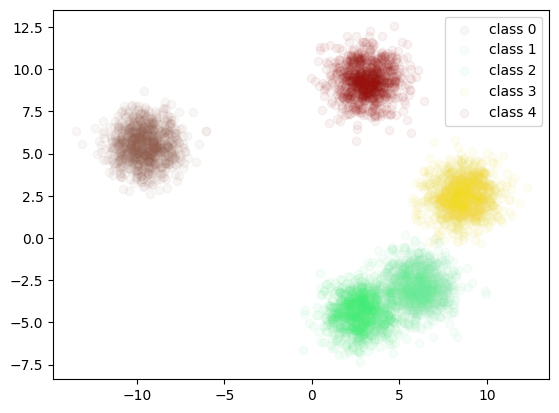

In [4]:
# Dataset Initialization

seed = 18222
set_seed(seed)

num_samples = 10000
batch_size = 1000
dimension = 2
num_classes = 5
magnitude = 10

mog_data = MoGData(dimension=dimension, num_classes=num_classes, magnitude=magnitude)
mog_data.plot(num_samples=1000)
train_loader = DataLoader(CustomDataset(*mog_data.sample_data(num_samples=num_samples)),
                          batch_size=batch_size,
                          shuffle=True)

In [5]:
# Define the DNN model
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [6]:
# Define loss functions
class CrossEntropy(nn.Module):
    def __init__(self):
        super(CrossEntropy, self).__init__()

    def forward(self, logits, target):

        target = target.view(-1, 1)
        logpt = F.log_softmax(logits, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        loss = -1 * logpt

        return loss.mean()

In [7]:
learning_rate = 1

# Training the model with cross entropy loss
model = DNN(dimension, 10, num_classes).cuda()  # Move model to GPU
ce = CrossEntropy().cuda()  # Move loss function to GPU
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
pbar_ce = tqdm(total=len(train_loader))

for i, (inputs, labels) in enumerate(train_loader):
  inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU
  optimizer.zero_grad()
  logits = model(inputs)
  loss = ce(logits, labels)
  loss.backward()
  optimizer.step()
  pbar_ce.update(1)
pbar_ce.close()

100%|██████████| 50/50 [00:00<00:00, 376.30it/s]


In [8]:
# generate a test dataset from the distribution
test_inputs, test_labels = mog_data.sample_data(num_samples=5000)
test_gt_probs = mog_data.compute_likelihood_ratio(test_labels, test_inputs)


test_inputs = torch.from_numpy(test_inputs).cuda()
test_labels = torch.from_numpy(test_labels)
test_gt_probs = torch.from_numpy(test_gt_probs)
test_logits = model(test_inputs)

# get the probability of each class
probability = F.softmax(test_logits, dim=1).cpu()
confidence = probability.gather(1, test_labels.unsqueeze(1)).squeeze(1).cpu()
predictions = probability.argmax(dim=1).cpu()

# get the accuracy
accuracy = (predictions == test_labels).float().mean().item()
print("accuracy: ", accuracy)

accuracy:  0.5492799878120422


In [9]:
# get the calibrated error
calibrated_error = test_gt_probs - confidence
calibrated_error = calibrated_error.detach().cpu().numpy()
print("calibrated error: ", calibrated_error.mean().item())

calibrated error:  0.4429831746655963


In [10]:
# Focal Loss
focal_loss_error = (1 - confidence)
focal_loss_error = focal_loss_error.detach().cpu().numpy()
focal_loss_pearson_corr, _ = pearsonr(calibrated_error, focal_loss_error)
print("Focal Loss Pearson Correlation: ", focal_loss_pearson_corr)
print("Focal Loss Calibrated Error: ", (focal_loss_error-calibrated_error).mean().item())



Focal Loss Pearson Correlation:  0.9573819118883022
Focal Loss Calibrated Error:  0.020898102647636113


In [11]:
# Dual Focal Loss
probability_sorted, _ = torch.sort(probability, dim=1, descending=True)
second_largest_prob = probability_sorted[:, 1]
dual_focal_loss_error = (1 - confidence + second_largest_prob)
dual_focal_loss_error = dual_focal_loss_error.detach().cpu().numpy()
dual_focal_loss_pearson_corr, _ = pearsonr(calibrated_error, dual_focal_loss_error)
print("Dual Focal Loss Pearson Correlation: ", dual_focal_loss_pearson_corr)
print("Dual Focal Loss Calibrated Error: ", (dual_focal_loss_error-calibrated_error).mean().item())


Dual Focal Loss Pearson Correlation:  0.9611656045858563
Dual Focal Loss Calibrated Error:  0.22089481478755216


In [12]:
# MSE
test_labels_one_hot = torch.zeros(test_labels.shape[0], num_classes)
test_labels_one_hot.scatter_(1, test_labels.unsqueeze(1), 1)
mse = (test_labels_one_hot - probability).abs()
mse = mse.sum(dim=-1)
print(mse.shape)
mse = mse.detach().cpu().numpy()
mse_pearson_corr, _ = pearsonr(calibrated_error, mse)
print("MSE Pearson Correlation: ", mse_pearson_corr)
print("MSE Calibrated Error: ", (mse-calibrated_error).mean().item())

torch.Size([25000])
MSE Pearson Correlation:  0.9573819099371601
MSE Calibrated Error:  0.4847794335250497


In [29]:
# ECE
ece_value = torch.zeros(len(confidence)).to(confidence.device)
ece, bin_dict = expected_calibration_error(confidence, predictions, test_labels)
for i, p in enumerate(confidence):
    for bin_index, bin_info in bin_dict.items():
        lower_bound = bin_info.get('lower_bound', 0)
        upper_bound = bin_info.get('upper_bound', 1)
        if lower_bound <= p < upper_bound:
            ece_value[i] = bin_info.get('ece', None).abs()
            break
        
# AdaECE
ada_ece_values = torch.zeros(len(confidence)).to(confidence.device)
sorted_prob, sorted_indices = torch.sort(probability)
ada_bin_num = 15
bin_size = len(test_inputs) // ada_bin_num
ada_ece, ada_bin_dict = adaECE_error(confidence, predictions.float(), test_labels.float())
print(ada_bin_dict)
for i, p in enumerate(confidence):
    for bin_index, bin_info in ada_bin_dict.items():
        lower_bound = bin_info.get('lower_bound', 0)
        upper_bound = bin_info.get('upper_bound', 1)
        if lower_bound <= p < upper_bound:
            ada_ece_values[i] = abs(bin_info.get('accuracy_in_bin', None) - bin_info.get('avg_confidence_in_bin', None))
            break
        
classwise_ece, per_class_ece = ClasswiseECELoss()(test_logits, torch.tensor(test_labels))
classwise_ece_values = per_class_ece[test_labels]
print(per_class_ece)

ece_weight = (ece_value).cpu().abs() + ada_ece_values.cpu().abs() 
# + classwise_ece_values.cpu().abs()
ece_pearson_corr, _ = spearmanr(ece_weight.detach().numpy(), calibrated_error)
print("ECE Spearman Correlation: ", ece_pearson_corr)



defaultdict(<class 'dict'>, {0: {'lower_bound': 0.0, 'upper_bound': 0.2956041991710663, 'prop_in_bin': 0.2500399947166443, 'accuracy_in_bin': 0.0, 'avg_confidence_in_bin': 0.2530280351638794, 'calibration_gap': 0.2530280351638794}, 1: {'lower_bound': 0.2956041991710663, 'upper_bound': 0.2956041991710663, 'prop_in_bin': 0.0, 'accuracy_in_bin': 0.0, 'avg_confidence_in_bin': 0.0, 'calibration_gap': 0.0}, 2: {'lower_bound': 0.2956041991710663, 'upper_bound': 0.2956041991710663, 'prop_in_bin': 0.0, 'accuracy_in_bin': 0.0, 'avg_confidence_in_bin': 0.0, 'calibration_gap': 0.0}, 3: {'lower_bound': 0.2956041991710663, 'upper_bound': 0.3080027103424072, 'prop_in_bin': 0.1995600014925003, 'accuracy_in_bin': 0.0, 'avg_confidence_in_bin': 0.3080027103424072, 'calibration_gap': 0.3080027103424072}, 4: {'lower_bound': 0.3080027103424072, 'upper_bound': 0.3080027103424072, 'prop_in_bin': 0.0, 'accuracy_in_bin': 0.0, 'avg_confidence_in_bin': 0.0, 'calibration_gap': 0.0}, 5: {'lower_bound': 0.3080027103

/tmp/ipykernel_3106380/2029475013.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classwise_ece, per_class_ece = ClasswiseECELoss()(test_logits, torch.tensor(test_labels))


In [14]:
scaled_model = ModelWithTemperature(model, True)
test_set = CustomDataset(test_inputs, test_labels)
test_loader = DataLoader(test_set,
                          batch_size=batch_size,
                          shuffle=True)
scaled_model.set_temperature(test_loader, cross_validate=False)
T_opt = scaled_model.get_temperature()
scaled_logits = test_logits / T_opt
scaled_probability = F.softmax(scaled_logits, dim=1).cpu()
scaled_confidence = scaled_probability.gather(1, test_labels.unsqueeze(1)).squeeze(1).cpu()
scaled_predictions = scaled_probability.argmax(dim=1).cpu()
scaled_accuracy = (scaled_predictions == test_labels).float().mean().item()
print("Scaled Accuracy: ", scaled_accuracy)

Before temperature - NLL: 9241.995, ECE: 0.003
Optimal temperature: 10.000
After temperature - NLL: 925.110, ECE: 0.057
Scaled Accuracy:  0.5492799878120422


In [15]:
# Focal Loss
scaled_focal_loss_error = (1 - scaled_confidence)
scaled_focal_loss_error = scaled_focal_loss_error.detach().cpu().numpy()
scaled_focal_loss_pearson_corr, _ = pearsonr(calibrated_error, scaled_focal_loss_error)
print("Scaled Focal Loss Pearson Correlation: ", scaled_focal_loss_pearson_corr)
# print("Scaled Focal Loss Calibrated Error: ", (scaled_focal_loss_error-calibrated_error).mean().item())


Scaled Focal Loss Pearson Correlation:  0.961664628169164


In [16]:
# Dual Focal Loss
scaled_probability_sorted, _ = torch.sort(scaled_probability, dim=1, descending=True)
scaled_second_largest_prob = scaled_probability_sorted[:, 1]
scaled_dual_focal_loss_error = (1 - scaled_confidence + scaled_second_largest_prob)
scaled_dual_focal_loss_error = scaled_dual_focal_loss_error.detach().cpu().numpy()
scaled_dual_focal_loss_pearson_corr, _ = pearsonr(calibrated_error, scaled_dual_focal_loss_error)
print("Scaled Dual Focal Loss Pearson Correlation: ", scaled_dual_focal_loss_pearson_corr)
# print("Scaled Dual Focal Loss Calibrated Error: ", (scaled_dual_focal_loss_error-calibrated_error).mean().item())


Scaled Dual Focal Loss Pearson Correlation:  0.961775772977655


In [17]:
# MSE
scaled_test_labels_one_hot = torch.zeros(test_labels.shape[0], num_classes)
scaled_test_labels_one_hot.scatter_(1, test_labels.unsqueeze(1), 1)
scaled_mse = (scaled_test_labels_one_hot - scaled_probability).abs()
scaled_mse = scaled_mse.sum(dim=-1)
print(scaled_mse.shape)
scaled_mse = scaled_mse.detach().cpu().numpy()
scaled_mse_pearson_corr, _ = pearsonr(calibrated_error, scaled_mse)
print("Scaled MSE Pearson Correlation: ", scaled_mse_pearson_corr)
# print("Scaled MSE Calibrated Error: ", (scaled_mse-calibrated_error).mean().item())

torch.Size([25000])
Scaled MSE Pearson Correlation:  0.9616646279054695


In [28]:
# ECE
scaled_ece_value = torch.zeros(len(scaled_confidence)).to(scaled_confidence.device)
scaled_ece, scaled_bin_dict = expected_calibration_error(scaled_confidence, scaled_predictions, test_labels)
for i, p in enumerate(scaled_confidence):
    for bin_index, bin_info in scaled_bin_dict.items():
        lower_bound = bin_info.get('lower_bound', 0)
        upper_bound = bin_info.get('upper_bound', 1)
        if lower_bound <= p < upper_bound:
            scaled_ece_value[i] = abs(bin_info.get('ece', None))
            break
        
# AdaECE
scaled_ada_ece_values = torch.zeros(len(scaled_confidence)).to(scaled_confidence.device)
scaled_sorted_prob, scaled_sorted_indices = torch.sort(scaled_probability)
scaled_ada_bin_num = 15
scaled_bin_size = len(test_inputs) // scaled_ada_bin_num
scaled_ada_ece, scaled_ada_bin_dict = adaECE_error(scaled_confidence, scaled_predictions.float(), test_labels.float())
for i, p in enumerate(scaled_confidence):
    for bin_index, bin_info in scaled_ada_bin_dict.items():
        lower_bound = bin_info.get('lower_bound', 0)
        upper_bound = bin_info.get('upper_bound', 1)
        if lower_bound <= p < upper_bound:
            ada_ece_values[i] = abs(bin_info.get('calibration_gap', None))
            break
        
scaled_classwise_ece, scaled_per_class_ece = ClasswiseECELoss()(scaled_logits, torch.tensor(test_labels))
scaled_classwise_ece_values = scaled_per_class_ece[test_labels]

scaled_ece_weight = (scaled_ece_value).cpu() 
scaled_ece_weight += scaled_ada_ece_values.cpu()
# scaled_ece_weight = scaled_classwise_ece_values.cpu()
scaled_ece_pearson_corr, _ = spearmanr(scaled_ece_weight.detach().numpy(), calibrated_error)
print("Scaled ECE Spearman Correlation: ", scaled_ece_pearson_corr)




Scaled ECE Spearman Correlation:  0.8047748886259166


/tmp/ipykernel_3106380/1035803936.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_classwise_ece, scaled_per_class_ece = ClasswiseECELoss()(scaled_logits, torch.tensor(test_labels))
